In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import os
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# !cd /content/drive/MyDrive


In [ ]:
!ls

drive  sample_data


In [ ]:
# !unzip path_to_file.zip -d path_to_directory

!unzip /content/drive/MyDrive/Dataset.zip -d /content/drive/MyDrive/finial_project/


Archive:  /content/drive/MyDrive/Dataset.zip
replace /content/drive/MyDrive/finial_project/annotations/Cars0.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/drive/MyDrive/finial_project/annotations/Cars1.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: NA


In [ ]:
IMAGE_SIZE = 224


In [ ]:
img_dir = "/content/drive/MyDrive/finial_project/images" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
# files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))
    

In [ ]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]
        

In [ ]:
!ls

drive  sample_data


In [ ]:
path = '/content/drive/MyDrive/finial_project/annotations/'
text_files = ['/content/drive/MyDrive/finial_project/annotations/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [ ]:
resizeannotation("/content/drive/MyDrive/finial_project/annotations/Cars147.xml")

[188, 141, 101, 104]

In [ ]:
y[0]

[187, 144, 101, 104]

In [ ]:
np.array(X).shape

(433, 224, 224, 3)

In [ ]:
np.array(y).shape

(433, 4)

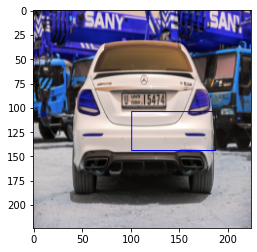

In [ ]:
#Example with the first image of the dataset
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


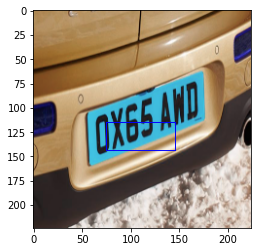

In [ ]:
#Example with the second image of the dataset
image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(0, 0, 255))
plt.imshow(image)
plt.show()

In [ ]:
#Transforming the image from matrix to an array
X=np.array(X)
y=np.array(y)
#Renormalisation
X = X / 255
y = y / 255

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [ ]:
from keras.models import Sequential

from keras.layers import Dense, Flatten

from keras.applications.vgg16 import VGG16

In [ ]:
# Create the model
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                         

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=1)

Epoch 1/20
9/9 [==============================] - 18s 573ms/step - loss: 0.0636 - accuracy: 0.4275 - val_loss: 0.0304 - val_accuracy: 0.6000
Epoch 2/20
9/9 [==============================] - 2s 191ms/step - loss: 0.0295 - accuracy: 0.5072 - val_loss: 0.0302 - val_accuracy: 0.5571
Epoch 3/20
9/9 [==============================] - 2s 191ms/step - loss: 0.0196 - accuracy: 0.5725 - val_loss: 0.0304 - val_accuracy: 0.4571
Epoch 4/20
9/9 [==============================] - 2s 193ms/step - loss: 0.0153 - accuracy: 0.7029 - val_loss: 0.0336 - val_accuracy: 0.4714
Epoch 5/20
9/9 [==============================] - 2s 191ms/step - loss: 0.0128 - accuracy: 0.7319 - val_loss: 0.0365 - val_accuracy: 0.5714
Epoch 6/20
9/9 [==============================] - 2s 192ms/step - loss: 0.0115 - accuracy: 0.6522 - val_loss: 0.0381 - val_accuracy: 0.3571
Epoch 7/20
9/9 [==============================] - 2s 191ms/step - loss: 0.0091 - accuracy: 0.7391 - val_loss: 0.0347 - val_accuracy: 0.5000
Epoch 8/20
9/9 [===

In [ ]:
model.save('my_model.h5', overwrite=True) 


In [ ]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

In [ ]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()
plot_scores(train)


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test,steps=int(100))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)


In [ ]:
y_cnn = model.predict(X_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

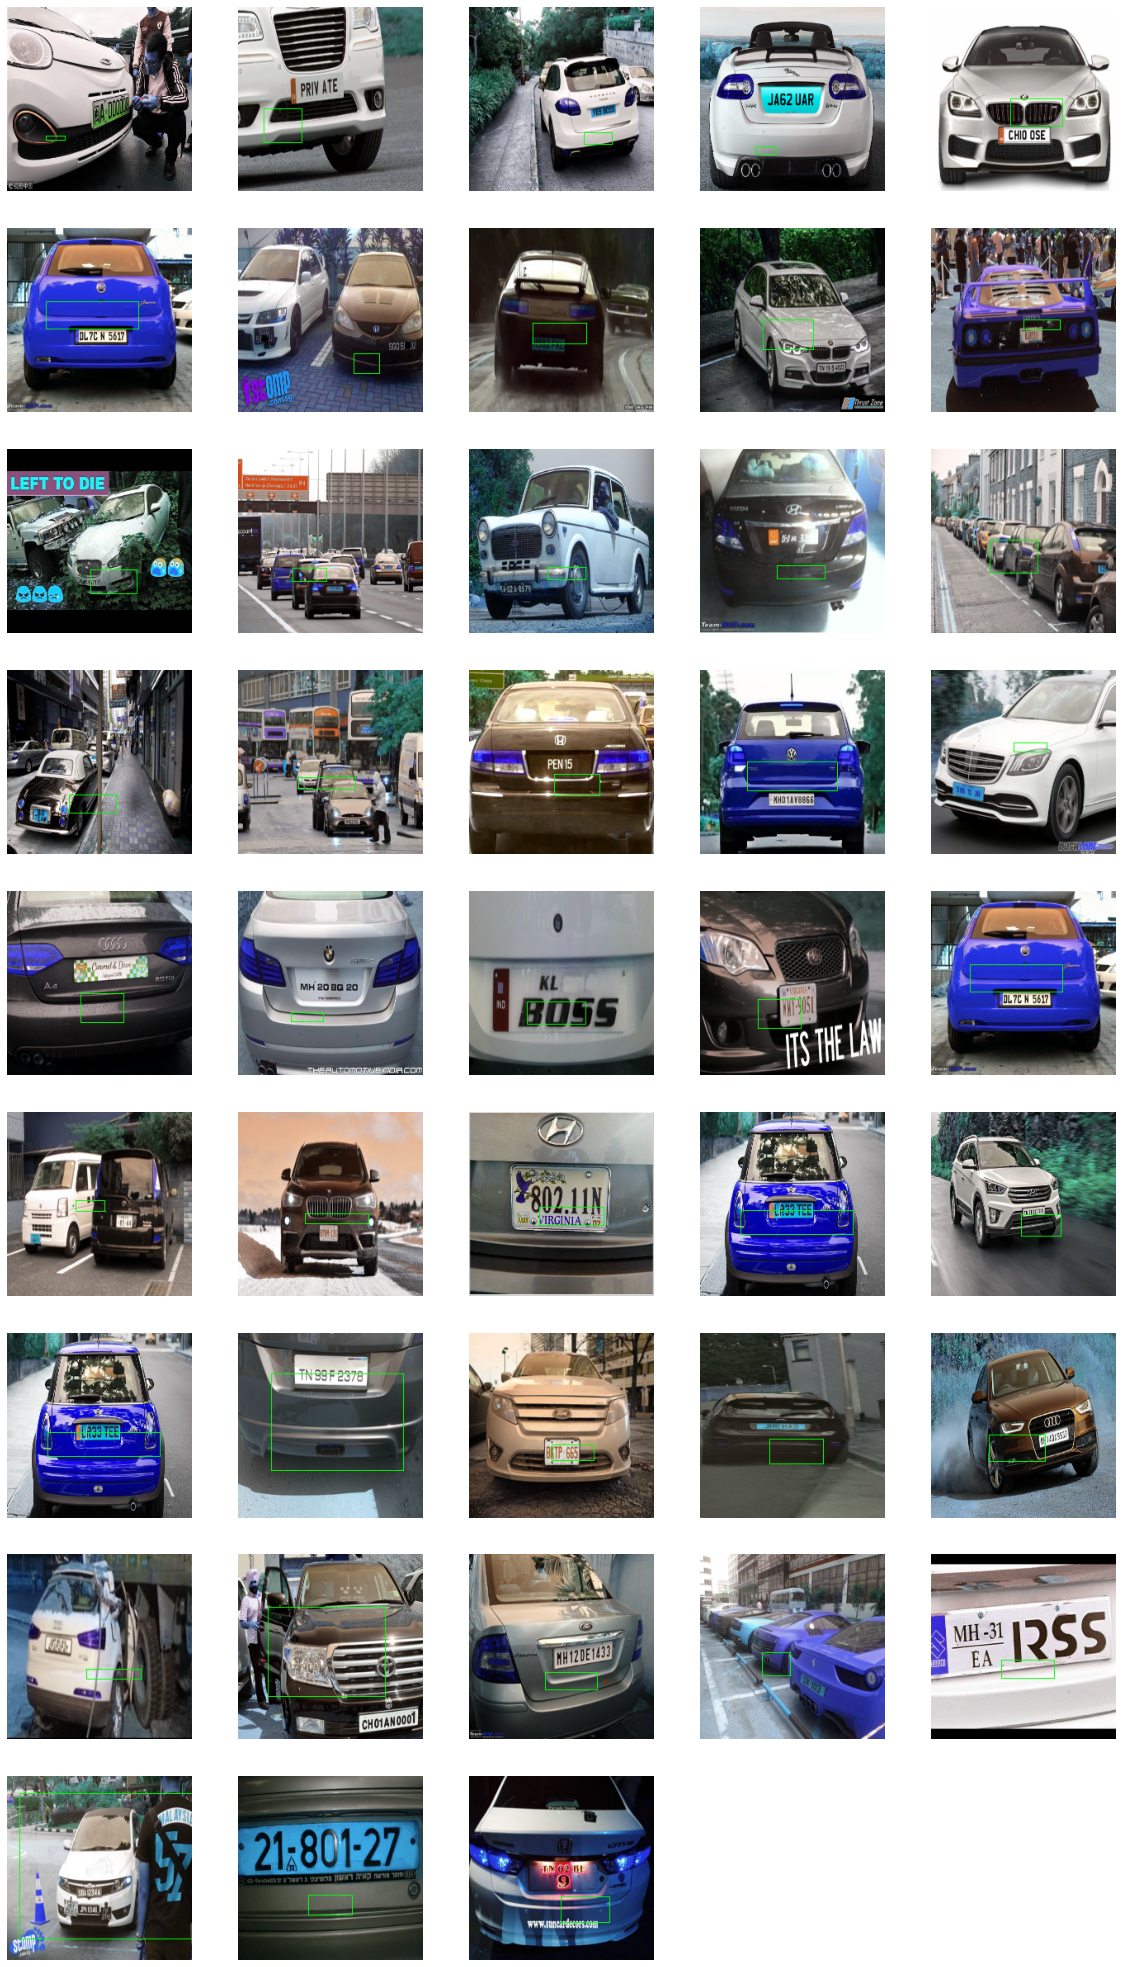

In [ ]:
plt.figure(figsize=(20,40))
for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)

### The OCR

In [ ]:
cd /content/drive/MyDrive/finial_project/OCR/

/content/drive/MyDrive/finial_project/OCR


In [ ]:
!pip install ArabicOcr


In [ ]:
from ArabicOcr import arabicocr
out_image='out2.jpg'
Red_car_path='/content/drive/MyDrive/finial_project/result/plate2.jpg'
results=arabicocr.arabic_ocr(Red_car_path, out_image)
print(results)

In [ ]:
words=[]
for i in range(len(results)):	
		word=results[i][1]
		words.append(word)

In [ ]:
print(words)
words.pop(0)
words.pop(0)
print(words)


### Load Model From Drive and use it 

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
cd /content/drive/MyDrive/finial_project/

In [ ]:
!ls


In [ ]:
from keras.models import load_model
model = load_model('my_model.h5')

In [ ]:
from matplotlib import pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
car_path = '/content/drive/MyDrive/finial_project/images/Cars0.png'
car = cv2.imread(car_path,cv2.IMREAD_UNCHANGED)
car = cv2.resize(car, (224,224))

x= car.reshape((1,) + car.shape)
predicted_image = model.predict(x)

ny = predicted_image[0]*255

image2 = cv2.rectangle(car,(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 255))
plt.imshow(image2)

for i in range(4): #print the predicted corners 
  print(int(ny[i]))

### connect to backend

In [ ]:
IMAGE_SIZE=224
Red_car_path = '/content/drive/MyDrive/plate2.jpg'
Red_car = cv2.imread(Red_car_path,cv2.IMREAD_UNCHANGED)
Red_car = cv2.resize(Red_car, (IMAGE_SIZE,IMAGE_SIZE))
# img=np.array(img)
# img = tf.keras.applications.vgg16.preprocess_input(img, data_format=None)
cv2_imshow(Red_car)
Red_car.shape

In [ ]:
x= img.reshape((1,) + Red_car.shape)
predicted_image = model.predict(x)

ny = predicted_image[0]*255


In [ ]:
for i in range(4):
  print(int(ny[i]))

In [ ]:
image2 = cv2.rectangle(img,(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 255))
plt.imshow(image2)

In [ ]:
# image1 = cv2.rectangle(img,(80,150),(120,190),(0, 255, 255))
# plt.imshow(image1)

In [ ]:
import json
import requests
v="Hello at 2:38 pm"
plate=[v]
url = 'https://etg-plates.herokuapp.com/'

def main():
    eliufg = requests.post(url, json={"data": plate})
    print(eliufg)


if __name__ == '__main__':
    main()

In [ ]:
import json
import requests

plate_number = "قنص بيجرب 1:06 "

url = 'https://kartaa.herokuapp.com/'

def main():
    response = requests.post(url, json={"data": plate_number})
    print(response)
    exit(0)

if __name__ == '__main__':
    main()